In [1]:
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
import matplotlib.animation as ani
import logging, os
from datetime import datetime
from numba import njit, jit

## Set logger to log caching activity

In [2]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Reset cache location 

In [3]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Colorbar function

In [4]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel(f'Neutral Fraction, $x_{{HI}}$', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
#     for spine in ax.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
        
#     for spine in fig.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
    
    return cbar

## Cosmological Parameters (Default is used when no input is specified)

In [5]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [6]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [7]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
    direc='/lustre/aoc/projects/hera/wchin/21cmFAST-cache'
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2020-12-23 23:05:58.364771


2020-12-23 23:08:12,347 | INFO | Existing init_boxes found and read in (seed=230806296593).


Execution completed at 2020-12-23 23:08:12.349190
Execution time = 0:02:13.984419


# Ionized box

In [8]:
illustration_box = p21c.ionize_box(
    redshift=6.5, 
    init_boxes=init_cond,
).xH_box

2020-12-23 23:08:14,182 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).


# Illustrating the gaussian sphere method

## Measure the distance of each voxel to the center

In [9]:
@jit
def distance_from_coordinate(box_length):
    """
    Generate a cube of voxels.
    On each voxel, the distanace from the center is 
    calculated and the value is assigned to the voxel.
    jit by numba compiles what it can to machine code,
    the rest as python code.
    
    Parameters
    ----------
    box_length : int
        The length of each side of the cube.
        
    Returns
    -------
    distance : 3D-ndarray
        Cube of voxels with each voxel having its 
        distance from the center assigned to it.
    """
    # range of nummbers with 0 as the center    
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))
    # 3D mesh
    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    # generating cube and computing distacne for each voxel
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Make sure averaging region size is not larger than the box itself 

In [10]:
def check_averaging_radius_limit(averaging_radius, box_length):
    # check to see if averaging region is larger than the box itself
    if averaging_radius > (box_length-1)/2:
        raise ValueError(f'Averaging_radius = {averaging_radius} > \
{(box_length-1)/2} = (Box Length-1)/2, averaging region is larger than the box itself.')

# Drawing the averaging spheres

In [11]:
def illustration_sphere(
    box,
    radius,
    coordinates
):
    box=box.copy()
    
    # modified to return output_box_indices
    def modified_slicing_the_cube(ind1, ind2, box):
        """
        Selects a smaller cubical sub-region within a larger cube called 'box'.
        Incoorporates periodic boundary conditions, i.e. Pac-Man effect.
        This function takes in a set of slicing indices of one particular randomly
        selected cubical sub-region and returns the selected smaller cube.

        Parameters
        ----------
        ind1 : 1D ndarray, dtype: int
            The left bounds of the selected region in 1D respectively.
        ind2 : 1D ndarray, dtype: int
            The right bounds of the selected region in 1D respectively.
        box  : 3D ndarray, dtype: float32
            Data cube, when the smaller cubical
            sub-regions are being selected from.

        Returns
        -------
        output_box : 3D ndarray, dtype: float32
            The selected cubical smaller sub-region
            within the larger data cube.
        """

        if ind1[0] < 0:  # periodic boundary conditions
            # region that went beyond the zeroth voxel face of the
            # cube is replaced by the region at the 'box_length'th
            # voxel face of the cube with the same size.
            x_inds = np.r_[(ind1[0]+len(box)):len(box), 0:ind2[0]]
        elif ind2[0] > len(box):
            # region that went beyond the 'box_length'th voxel face
            # of the cube is replaced by the region at the zeroth 
            # voxel face of the cube with the same size.
            x_inds = np.r_[ind1[0]:len(box), 0:(ind2[0]-len(box))]
        else:
            # selected voxel is perfectly in the larger data cube.
            x_inds = np.r_[ind1[0]:ind2[0]]

        if ind1[1] < 0:
            y_inds = np.r_[(ind1[1]+len(box)):len(box), 0:ind2[1]]
        elif ind2[1] > len(box):
            y_inds = np.r_[ind1[1]:len(box), 0:(ind2[1]-len(box))]
        else:
            y_inds = np.r_[ind1[1]:ind2[1]]

        if ind1[2] < 0:
            z_inds = np.r_[(ind1[2]+len(box)):len(box), 0:ind2[2]]
        elif ind2[2] > len(box):
            z_inds = np.r_[ind1[2]:len(box), 0:(ind2[2]-len(box))]
        else:
            z_inds = np.r_[ind1[2]:ind2[2]]

        try:
            # box[indices]
            output_box_indices = np.ix_(x_inds, y_inds, z_inds)
            output_box = box[output_box_indices]

        except IndexError:  # sample region larger than box.
            print(f'ind1 = {ind1}')  # print useful info
            print(f'ind2 = {ind2}')  # for debugging
            print(f'box length = {len(box)}')
            print(f'x_ind1 = {ind1[0]}')
            print(f'x_ind2 = {ind2[0]}')
            print(f'x_inds = {x_inds}')
            print(f'y_ind1 = {ind1[1]}')
            print(f'y_ind2 = {ind2[1]}')
            print(f'y_inds = {y_inds}')
            print(f'z_ind1 = {ind1[2]}')
            print(f'z_ind2 = {ind2[2]}')
            print(f'z_inds = {z_inds}')

        return output_box, output_box_indices

    # modified to set the sphere to the average value
    def modified_top_hat_sphere_average(distance_box, radius, input_box):

        mean = np.mean(input_box[distance_box <= radius])
        # really, this is the out_put box, using same
        # variable location to recycle the space in memory
        input_box = np.where(distance_box <= radius, mean, input_box)

        return input_box

    
    # check to see if averaging region is largert than the box itself
    check_averaging_radius_limit(radius, len(box))

    # used as condition to define a sphere within a cube
    dist_frm_coord_box = distance_from_coordinate(radius*2+1)

    # iteration number of random cube region indices in the box
    # cube indices 
    rand_coord_inds1 = (coordinates-radius).astype(int)
    rand_coord_inds2 = (coordinates+radius+1).astype(int)  # ending index is not inclusive

    cube_region_box, cube_region_box_indices = modified_slicing_the_cube(
        rand_coord_inds1, 
        rand_coord_inds2, 
        box
    )
    
    # mean
    output_box = modified_top_hat_sphere_average(
        dist_frm_coord_box, 
        radius, 
        cube_region_box
    )
    
    box[cube_region_box_indices] = output_box
    
    return box

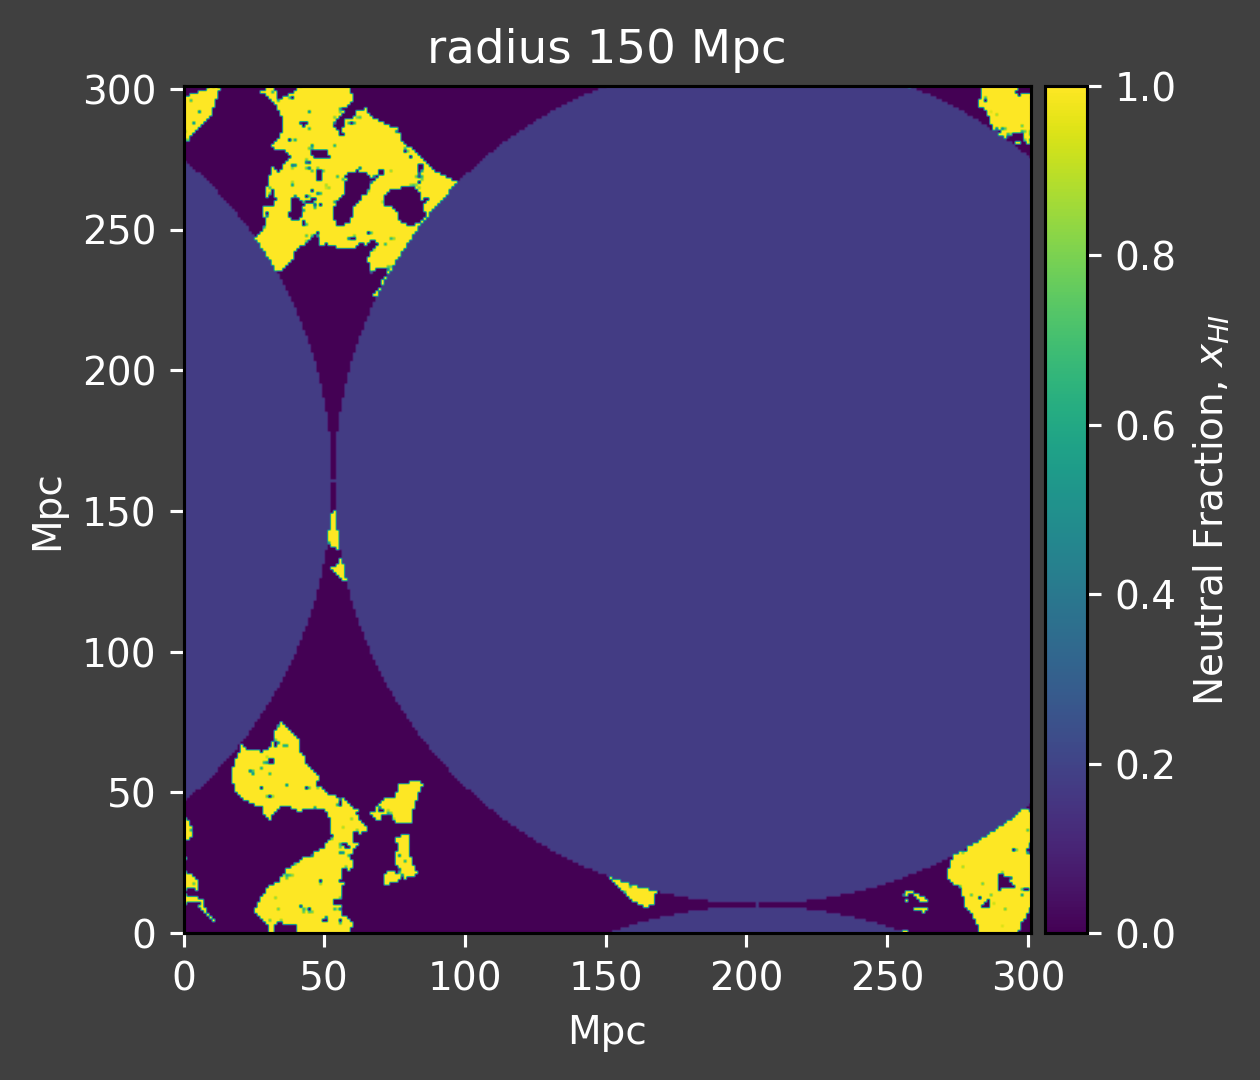

In [14]:
radius = 150

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius {radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

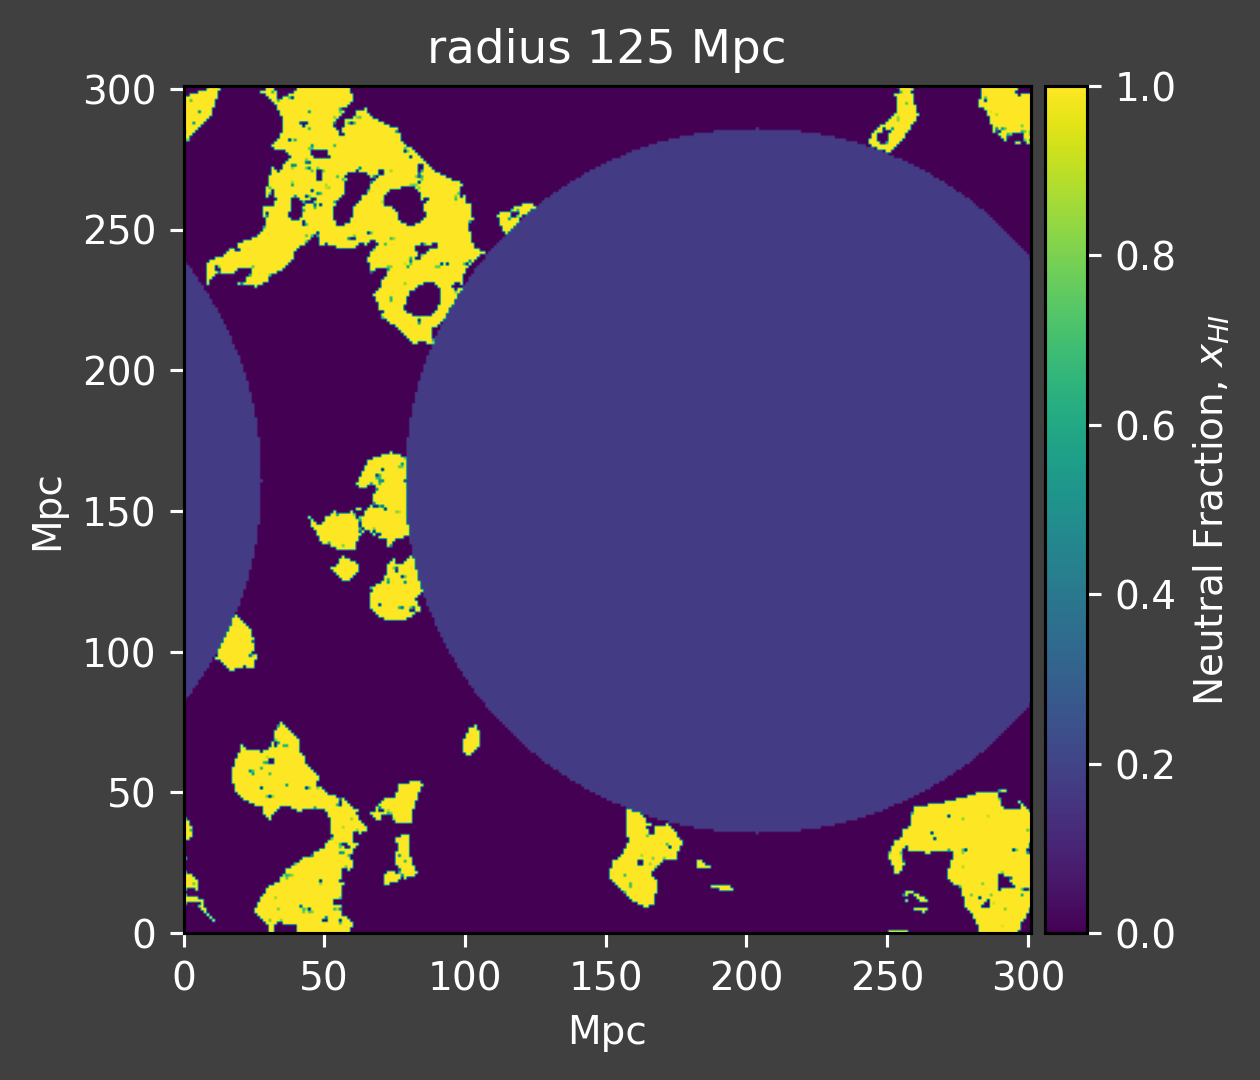

In [15]:
radius = 125

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius {radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

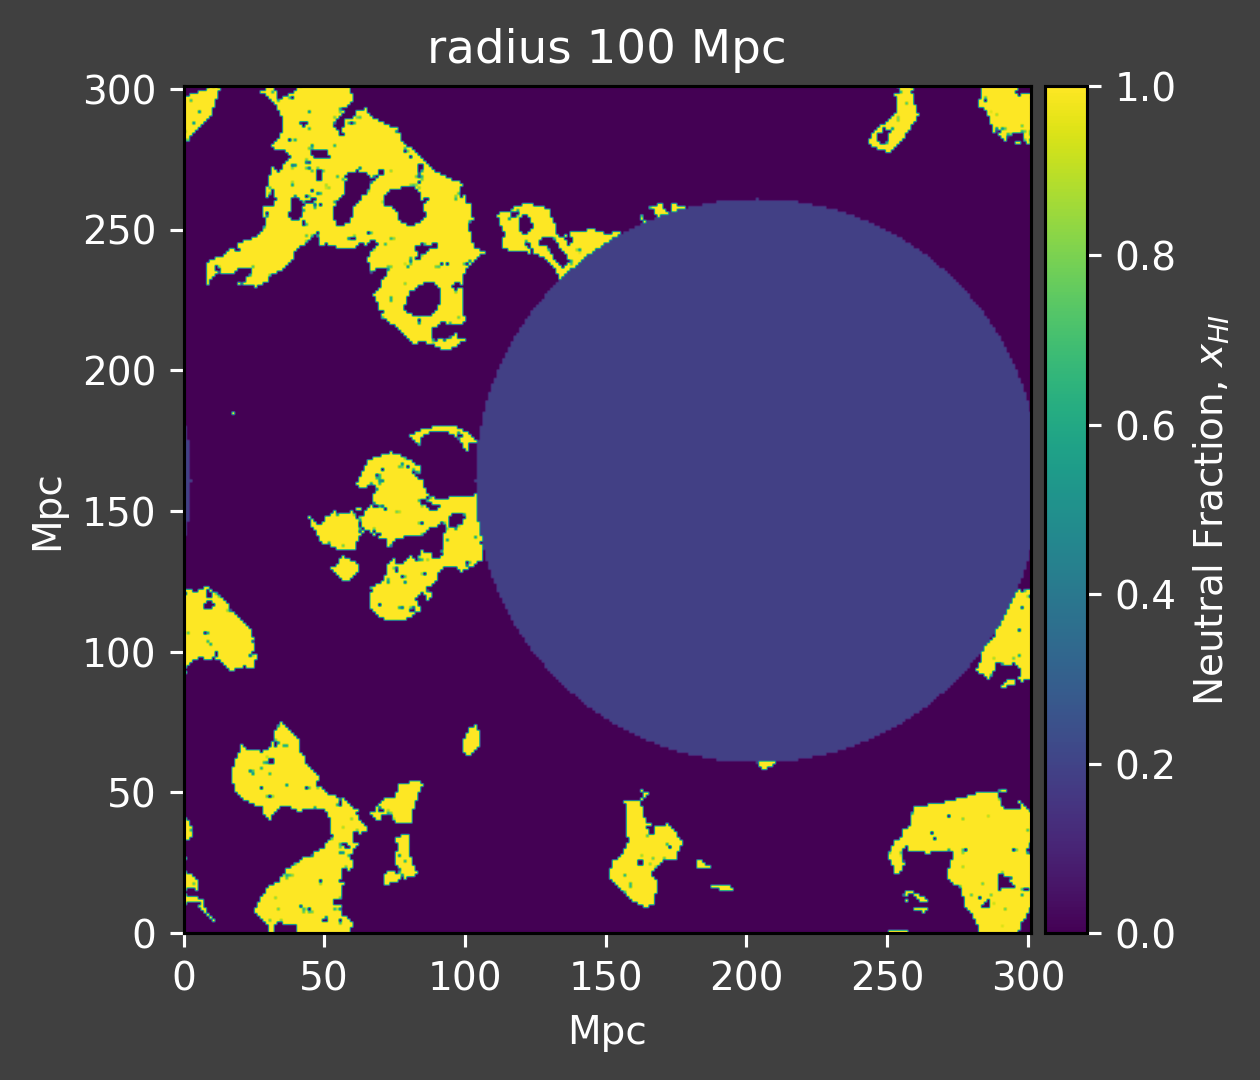

In [16]:
radius = 100

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius {radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

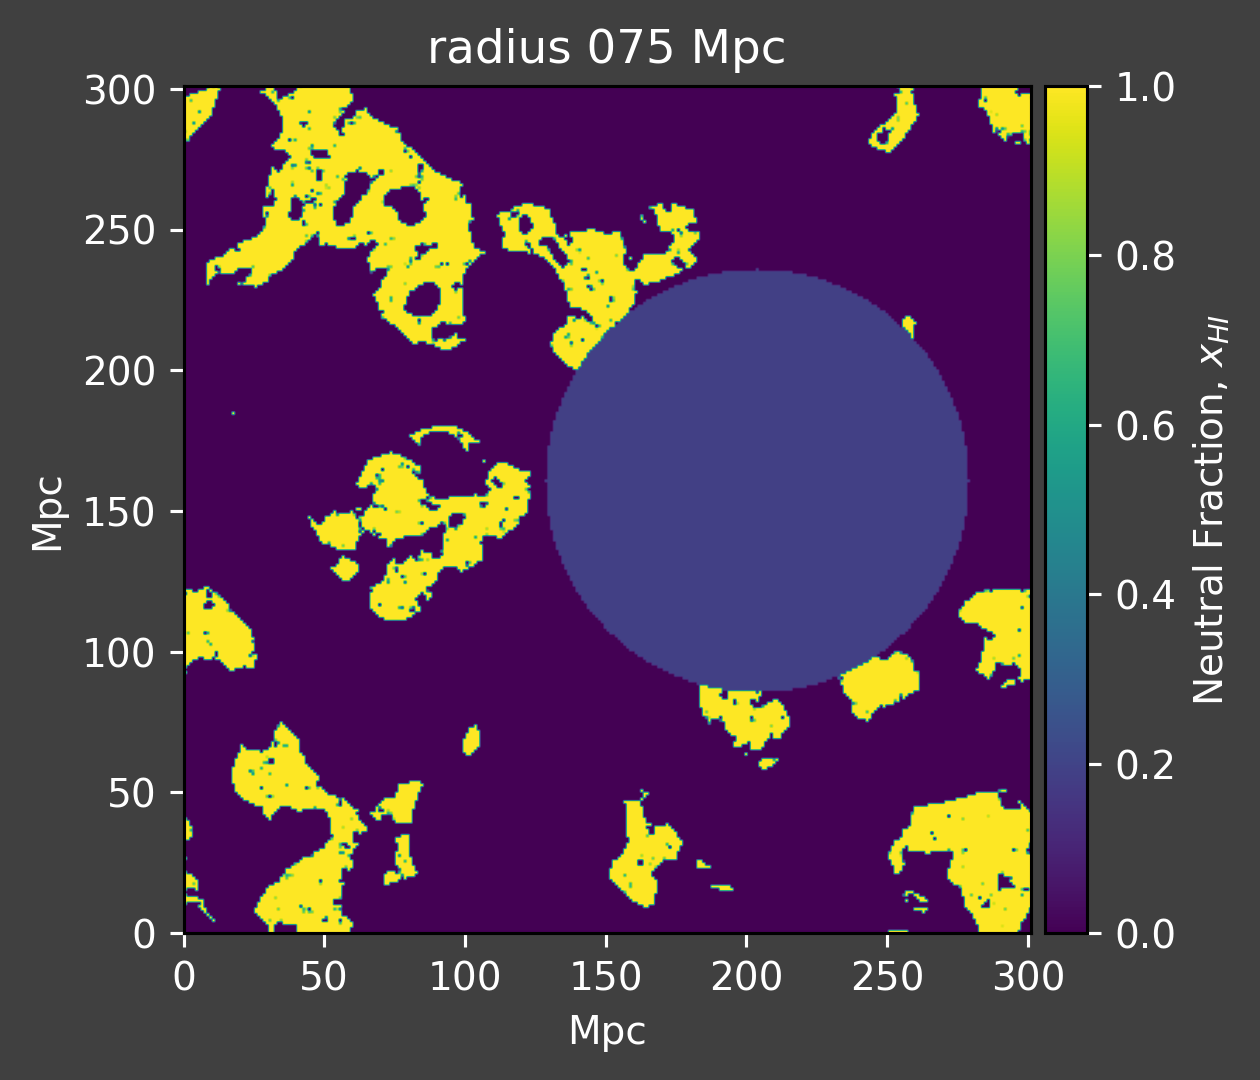

In [17]:
radius = 75

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 0{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

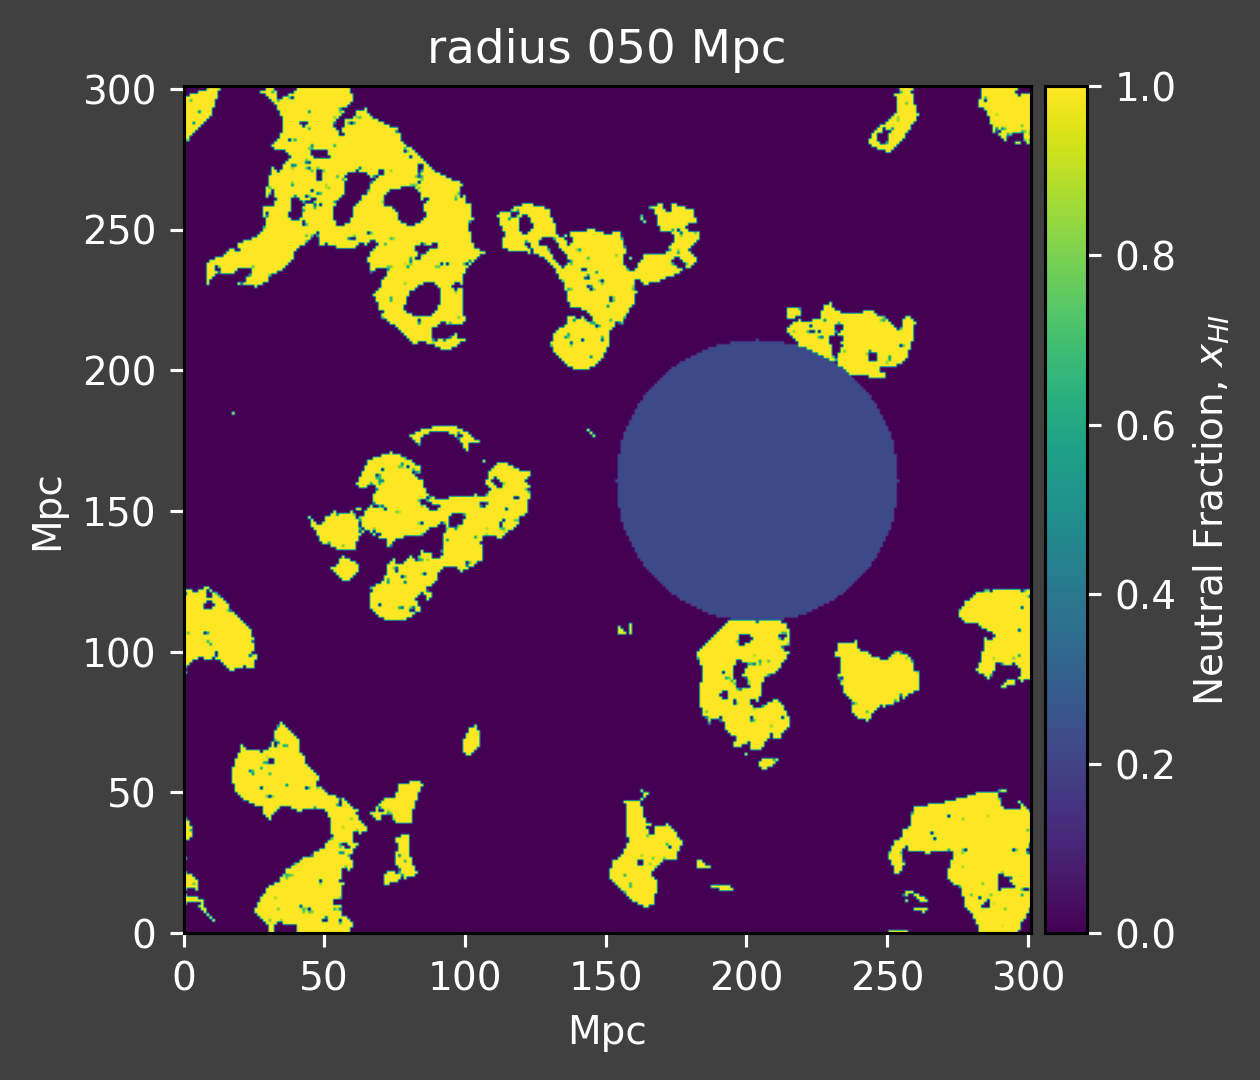

In [18]:
radius = 50

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 0{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

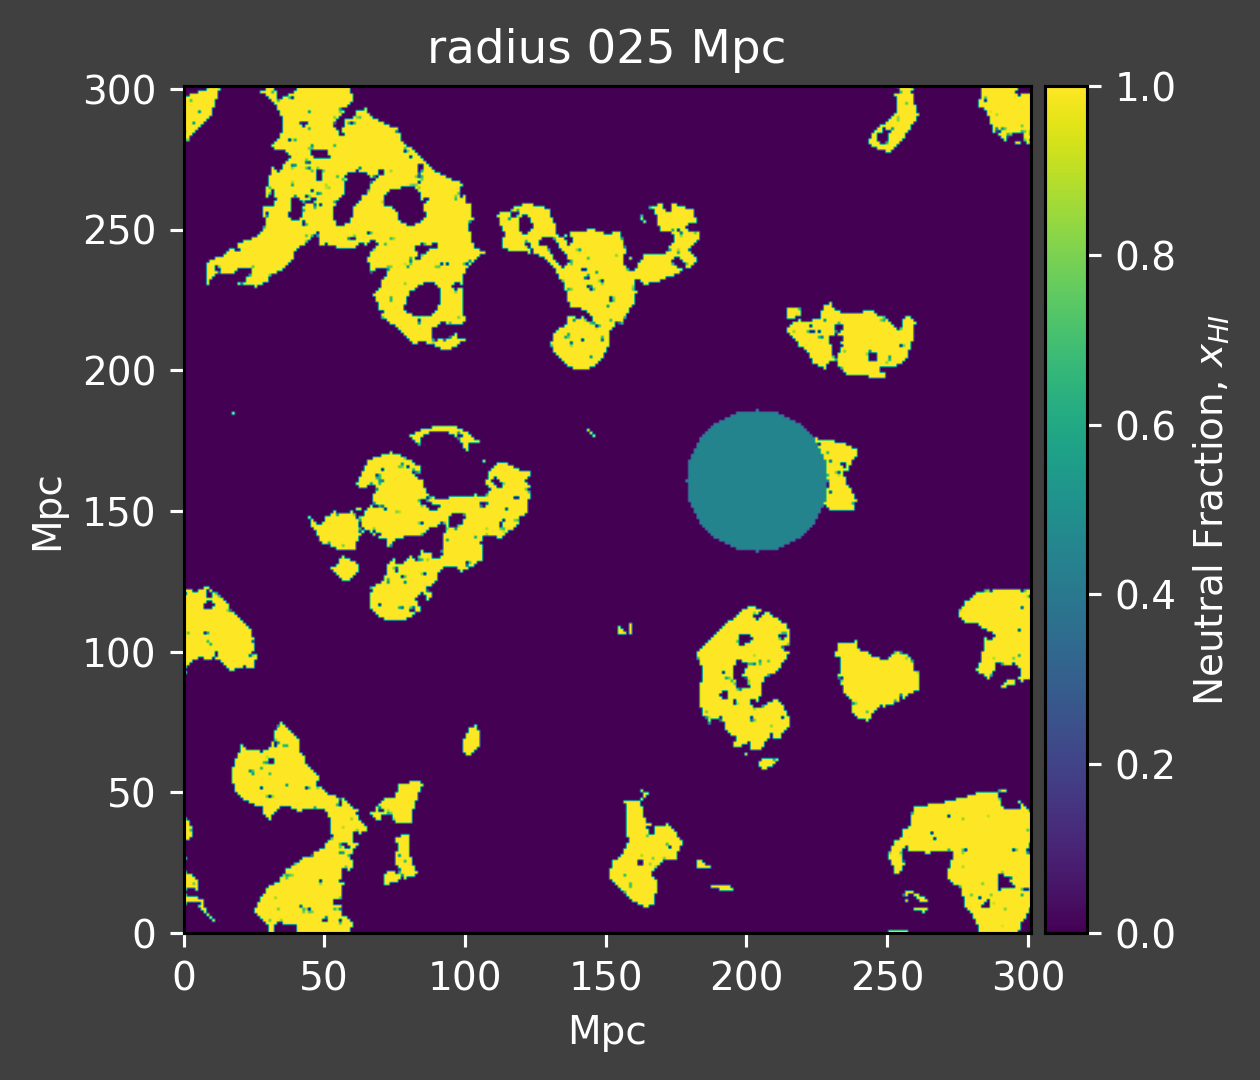

In [19]:
radius = 25

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 0{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

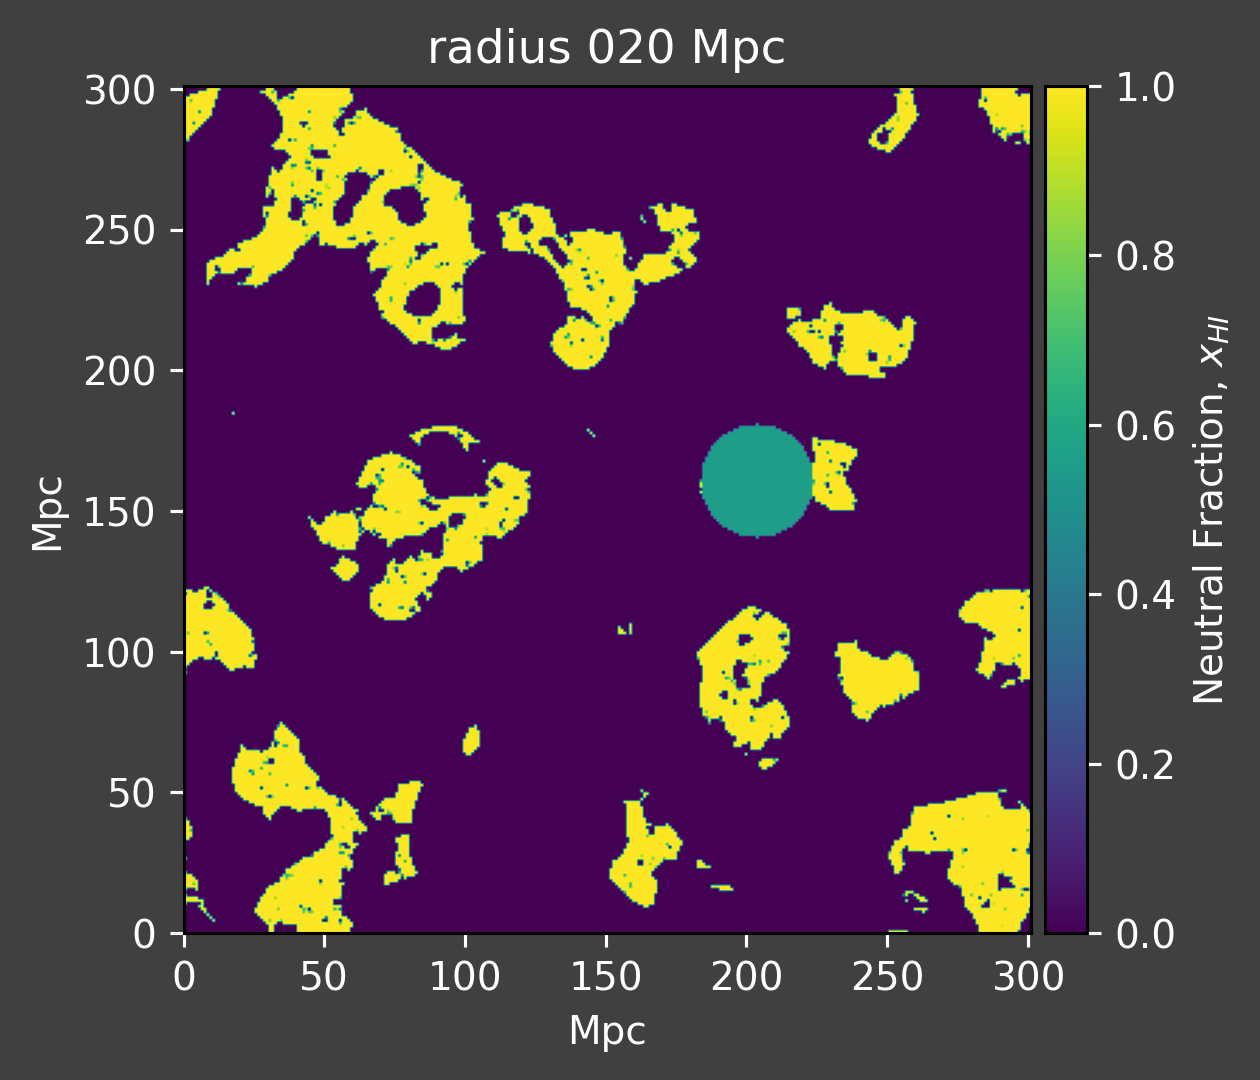

In [20]:
radius = 20

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 0{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

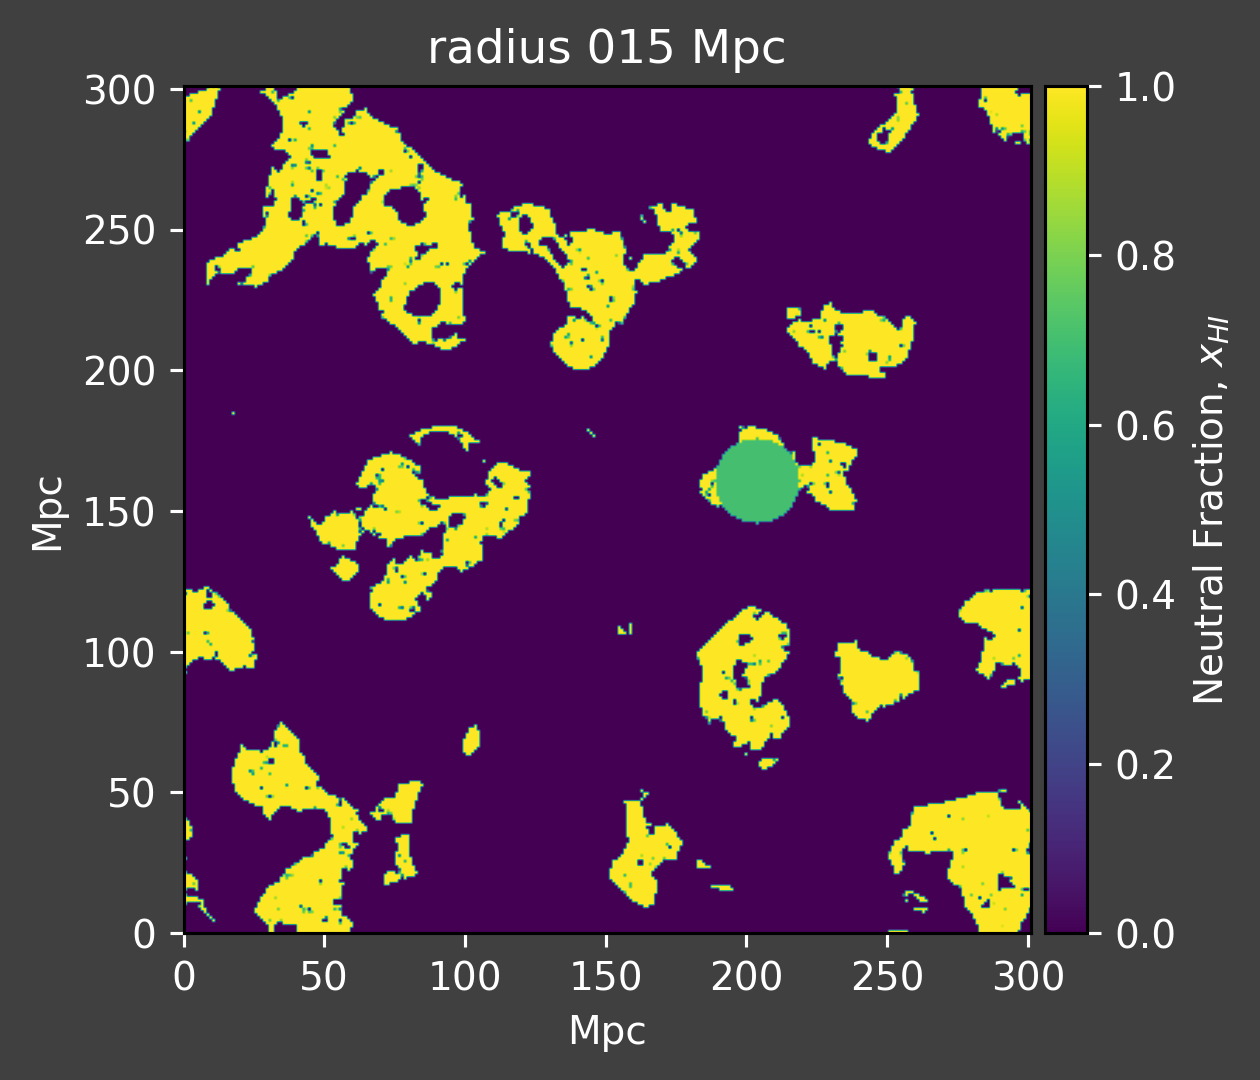

In [21]:
radius = 15

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 0{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

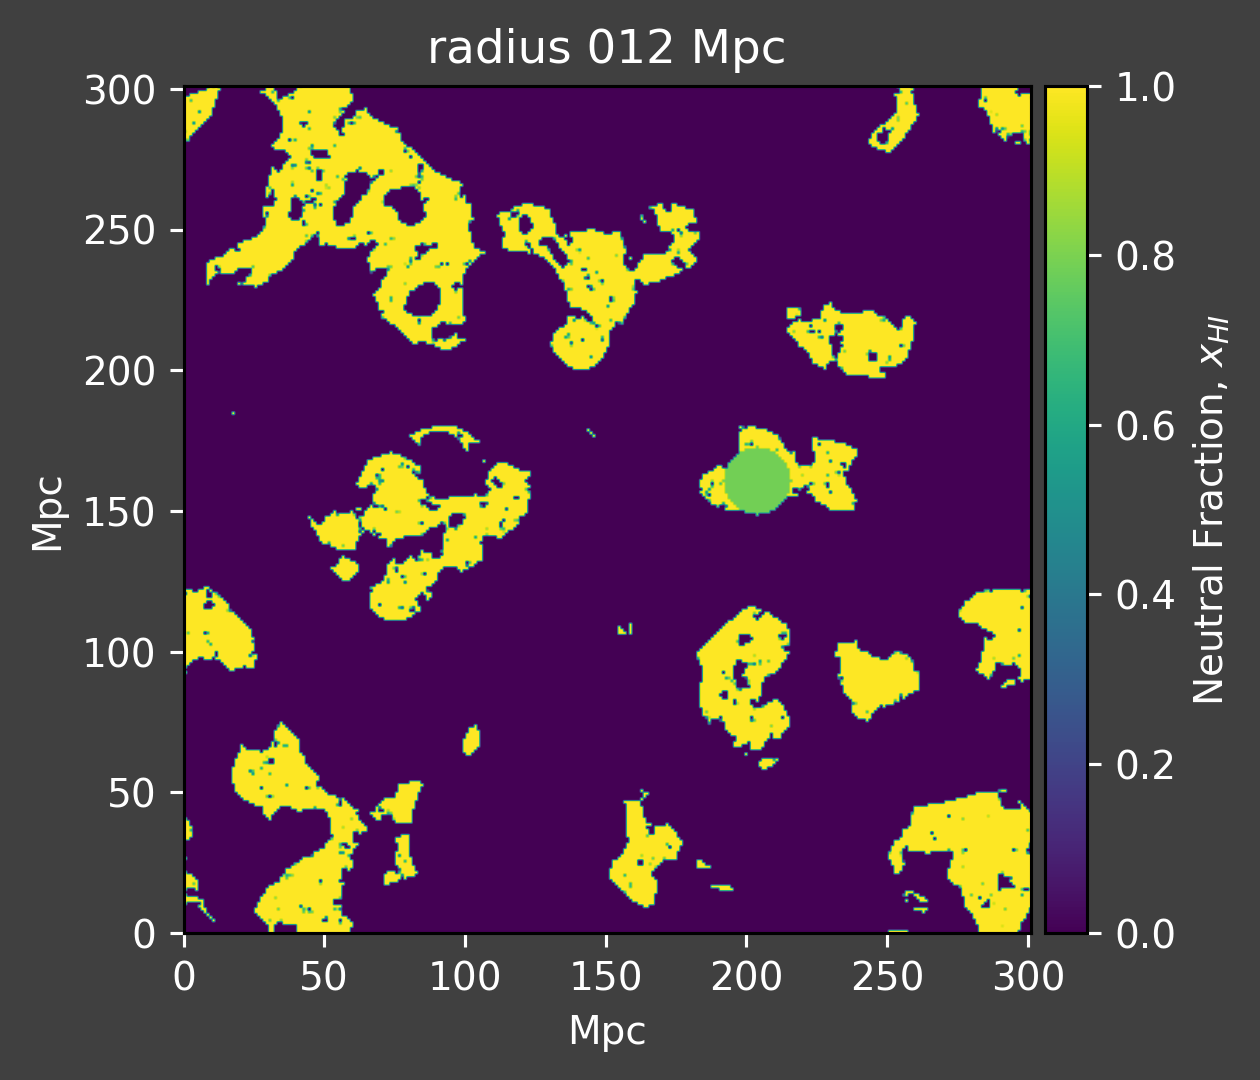

In [22]:
radius = 12

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 0{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

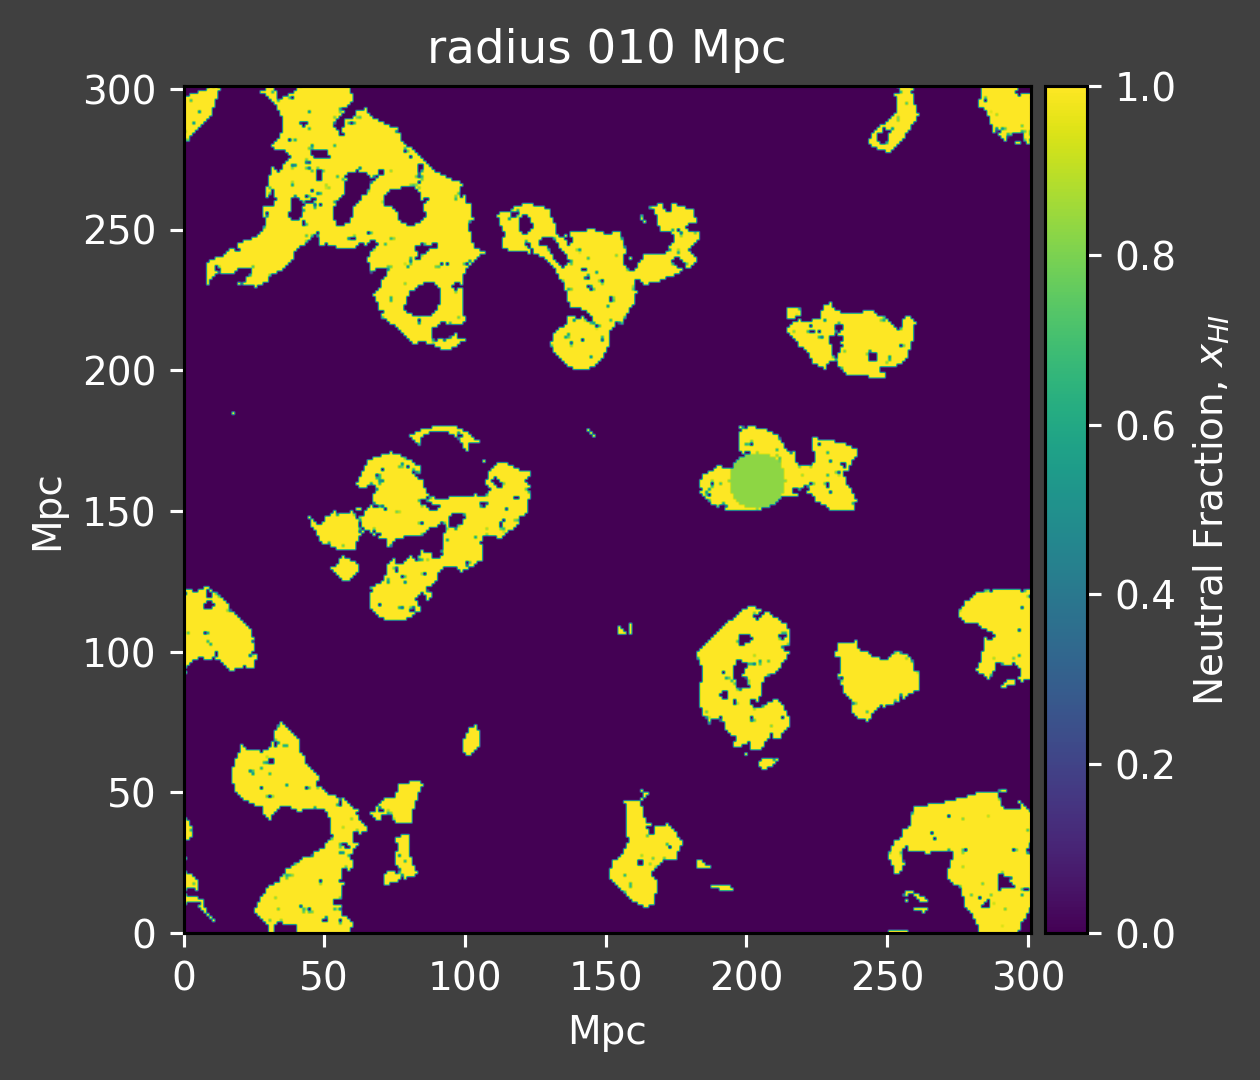

In [23]:
radius = 10

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 0{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

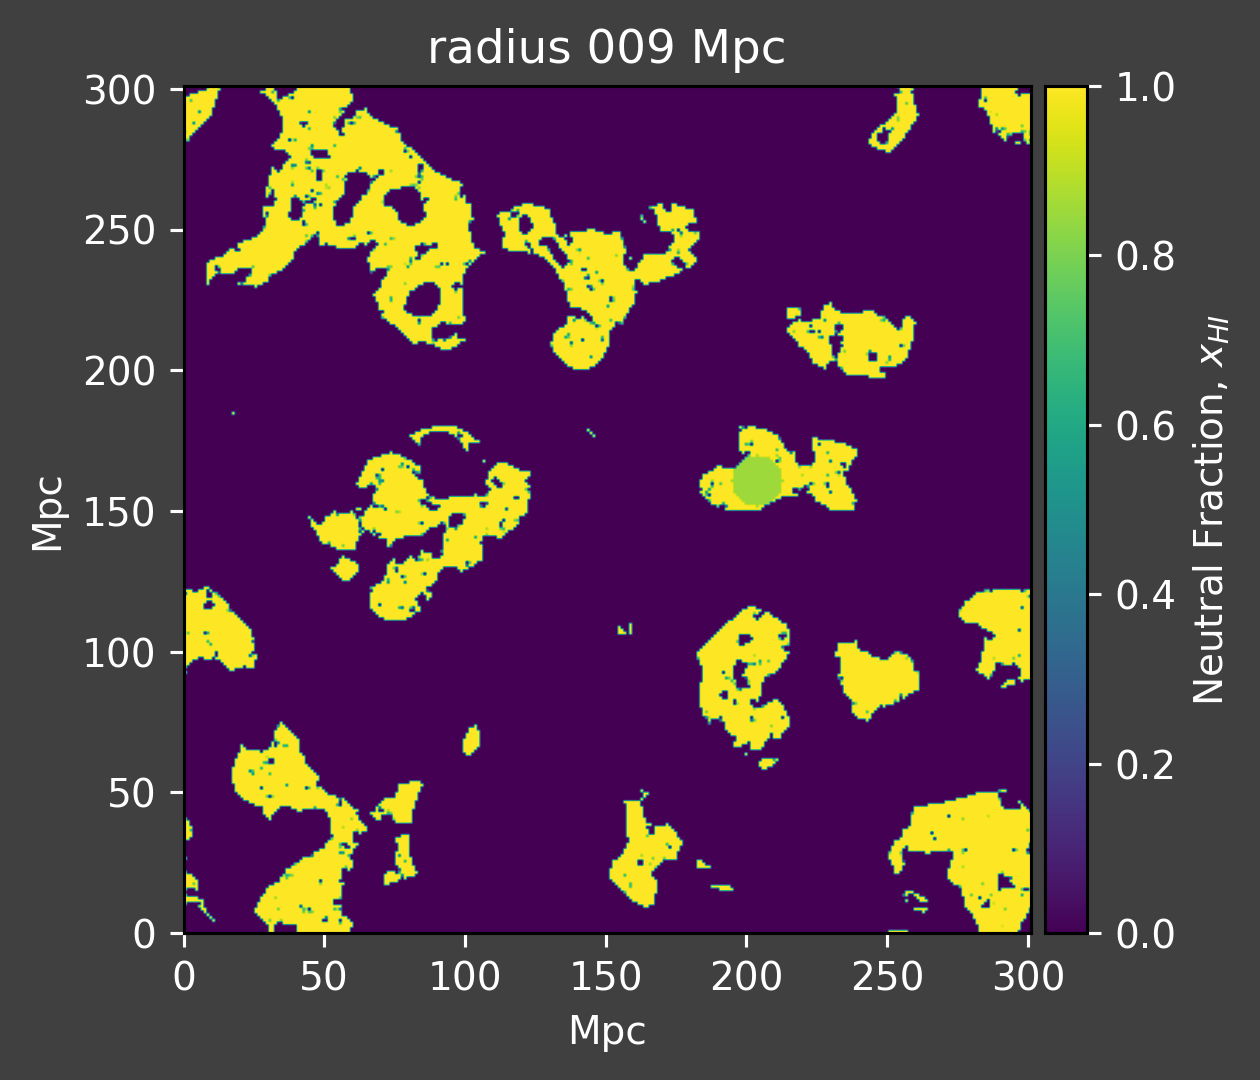

In [24]:
radius = 9

illustration_sphere_box = illustration_sphere(
    box=illustration_box,
    radius=radius,
    coordinates=np.array([150,160,203])  # z, y, x
)

plt.figure(dpi=280.5, facecolor='#404040')
color='w'
im = plt.imshow(
    illustration_sphere_box[150, :, :], 
    extent=(0,np.shape(illustration_sphere_box)[1],0,np.shape(illustration_sphere_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title(f'radius 00{radius} Mpc', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()